# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets and created a noise model (GMM- and  histogram- based) using the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```). Ensure that for `Mouse Actin`, the data to be denoised is named ```sample_attempt2.tif``` and not the diaphragm data. 

In [2]:
path='../../../data/Mouse actin/'
# Load the training data
data=imread(path+'sample_attempt2.tif')
dataName = 'mouseactin'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
try:
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
except:
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     path, torch.Tensor(params['trained_weight']), 
                                                                     n_gaussian=int(nameNoiseModel.split('_')[-3]), 
                                                                     n_coeff=int(nameNoiseModel.split('_')[-2]), min_sigma=200)
    

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 6.0290021896362305+-(2SEM)0.1928014100006747      
Epoch 1 finished      
avg. loss: 6.019017887115479+-(2SEM)0.23278984425700333      
Epoch 2 finished      
avg. loss: 5.903635239601135+-(2SEM)0.20107484519124075      
Epoch 3 finished      
avg. loss: 5.678647923469543+-(2SEM)0.1366382568827647      
Epoch 4 finished      
avg. loss: 5.633293199539184+-(2SEM)0.11503969967182284      
Epoch 5 finished      
avg. loss: 5.768342113494873+-(2SEM)0.18446359633921894      
Epoch 6 finished      
avg. loss: 5.689390969276428+-(2SEM)0.17589386728073036      
Epoch 7 finished      
avg. loss: 5.650571322441101+-(2SEM)0.15949942974980547      
Epoch 8 finished      
avg. loss: 5.601289939880371+-(2SEM)0.1220787493201488      
Epoch 9 finished      
avg. loss: 5.718114900588989+-(2SEM)0.16999617964240202      
Epoch 10 finished      
avg. loss: 5.698085951805115+-(2SEM)0.19457051020086727      
Epoch 11 finished      
avg. loss: 5.633546137809754+-(2SEM)0.1417

Epoch 92 finished      
avg. loss: 5.650753331184387+-(2SEM)0.15011701025857654      
Epoch 93 finished      
avg. loss: 5.667062115669251+-(2SEM)0.18093939016919136      
Epoch 94 finished      
avg. loss: 5.589469408988952+-(2SEM)0.1588587133878885      
Epoch    94: reducing learning rate of group 0 to 7.8125e-06.
Epoch 95 finished      
avg. loss: 5.617862892150879+-(2SEM)0.14097986460369596      
Epoch 96 finished      
avg. loss: 5.713989973068237+-(2SEM)0.18534321076749674      
Epoch 97 finished      
avg. loss: 5.541301512718201+-(2SEM)0.1798860685925518      
Epoch 98 finished      
avg. loss: 5.625598478317261+-(2SEM)0.13327596717189288      
Epoch 99 finished      
avg. loss: 5.520814371109009+-(2SEM)0.11536358180366933      
Epoch 100 finished      
avg. loss: 5.7202860593795775+-(2SEM)0.1362310313330208      
Epoch 101 finished      
avg. loss: 5.617715048789978+-(2SEM)0.17329443885489157      
Epoch 102 finished      
avg. loss: 5.687205839157104+-(2SEM)0.149897037782850

Epoch 181 finished      
avg. loss: 5.687293004989624+-(2SEM)0.18043342539526175      
Epoch 182 finished      
avg. loss: 5.580609560012817+-(2SEM)0.10207308896834112      
Epoch 183 finished      
avg. loss: 5.727149772644043+-(2SEM)0.1518785299740907      
Epoch 184 finished      
avg. loss: 5.652051877975464+-(2SEM)0.1532271218474066      
Epoch 185 finished      
avg. loss: 5.6471926927566525+-(2SEM)0.12050786666531016      
Epoch 186 finished      
avg. loss: 5.644739651679993+-(2SEM)0.17383452665430432      
Epoch 187 finished      
avg. loss: 5.627198958396912+-(2SEM)0.16034677988438029      
Epoch 188 finished      
avg. loss: 5.817280220985412+-(2SEM)0.18673340839480915      
Epoch   188: reducing learning rate of group 0 to 3.0518e-08.
Epoch 189 finished      
avg. loss: 5.681951975822448+-(2SEM)0.20037813220808015      
Epoch 190 finished      
avg. loss: 5.6922516345977785+-(2SEM)0.19914630919707546      
Epoch 191 finished      
avg. loss: 5.634433221817017+-(2SEM)0.15691

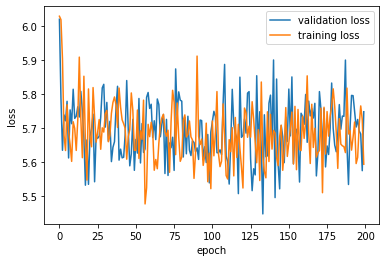

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()